# HHP Solution
Avadhoot Agasti (aagasti@iu.edu)

## Introduction
The Heritage Health Prize (HHP) was a data science challenge sponsored by The Heritage Provider Network on Kaggle. This project is about predicting future hospital stays using past information. The project is part of the Applied Machine Learning course syllabus for MS in Data Science Program at Indiana University. 

## Team
Avadhoot Agasti (aagasti@iu.edu)

## Project Phases
The project is divided in 4 projects as per the course expectation 

Phase 1: Grab data, EDA, metrics, baseline models (baseline pipeline PLEASE) and a brief report

Phase 2: [due Thursday, April 12]
Feature engineering + Hyperparameter tuning; in pipeline form

Phase 3: Week 14: [due Thursday, April 19]
Success/failure analysis,
Another round of Feature engineering + Hyperparameter tuning; Ensemble?

Phase 4: Week 15: [due Thursday, April 26]
Maybe another round of Feature engineering + Hyperparameter tuning;
Report and short video presentation (2 minute video presentation; 300 words)

## Softwares Required
The jupyter notebook uses Anaconda Version - conda 4.5.0. Apart from standard data science packages like numpy, scikit-learn and matplotlib, we use pandasql which supports SQL on top of dataframe. It can be installed using

        conda install pandasql 

## Data
The data is downloaded from course dropbox location https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADp4D50rGM61hpaSThZnqF3a/HHP_release3?dl=0

## Acknowledgements
We thank Prof. James Shanahan and TAs (Rohil Bansal and Qing Ke) for all the support and guidance. 



# Phase 1
The phase one of the project includes below steps:

Grabbing and Loading the data (Section 2.1)

EDA (Exploratory Data Analysis) (Section 2.2)

Defining Error Metrics (Section 2.3 and 2.4)

Creating baseline models (Section 2.4)

## Load Data

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import numpy as np
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
#Turn this flag to False to run all the tasks including hyper-parameter tuning
__avoid_run_heavy_tasks__ = True
__avoid_run_svm__ = True 
#SVM execution is taking too much time and from past runs we know that RF gives better result

In [3]:
data_path = os.path.join('source_data/')
claims_file = data_path + "Claims.csv"
members_file = data_path + "Members.csv"
drug_file = data_path + "DrugCount.csv"
lab_file = data_path + "LabCount.csv"
dihy2_file = data_path + "DaysInHospital_Y2.csv"
dihy3_file = data_path + "DaysInHospital_Y3.csv"

In [4]:
claims_df = pd.read_csv(claims_file)
members_df = pd.read_csv(members_file)
drug_df = pd.read_csv(drug_file)
lab_df = pd.read_csv(lab_file)
dihy2_df = pd.read_csv(dihy2_file)
dihy3_df = pd.read_csv(dihy3_file)

## EDA1: Explore Schema and Basic Data Properties

### Members Data

In [5]:
members_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113000 entries, 0 to 112999
Data columns (total 3 columns):
MemberID           113000 non-null int64
AgeAtFirstClaim    107247 non-null object
Sex                95448 non-null object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [6]:
members_df.head(2)

,MemberID,AgeAtFirstClaim,Sex
0,14723353,70-79,M
1,75706636,70-79,M


In [7]:
pysqldf("SELECT count(*), AgeAtFirstClaim FROM members_df group by AgeAtFirstClaim;")

,count(*),AgeAtFirstClaim
0,5753,None
1,10791,0-9
2,11319,10-19
3,8505,20-29
4,12435,30-39
5,16111,40-49
6,13329,50-59
7,12622,60-69
8,14514,70-79
9,7621,80+


### Claims Data

In [8]:
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668990 entries, 0 to 2668989
Data columns (total 14 columns):
MemberID                 int64
ProviderID               float64
Vendor                   float64
PCP                      float64
Year                     object
Specialty                object
PlaceSvc                 object
PayDelay                 object
LengthOfStay             object
DSFS                     object
PrimaryConditionGroup    object
CharlsonIndex            object
ProcedureGroup           object
SupLOS                   int64
dtypes: float64(3), int64(2), object(9)
memory usage: 285.1+ MB


In [9]:
claims_df.head(5)

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
1,97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2,2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
3,73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
4,11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [10]:
claims_df.count(axis=0)

MemberID                 2668990
ProviderID               2652726
Vendor                   2644134
PCP                      2661498
Year                     2668990
Specialty                2660585
PlaceSvc                 2661358
PayDelay                 2668990
LengthOfStay               71598
DSFS                     2616220
PrimaryConditionGroup    2657580
CharlsonIndex            2668990
ProcedureGroup           2665315
SupLOS                   2668990
dtype: int64

### Drug Count Data

In [11]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818241 entries, 0 to 818240
Data columns (total 4 columns):
MemberID     818241 non-null int64
Year         818241 non-null object
DSFS         818241 non-null object
DrugCount    818241 non-null object
dtypes: int64(1), object(3)
memory usage: 25.0+ MB


In [12]:
drug_df.head(2)

,MemberID,Year,DSFS,DrugCount
0,48925661,Y2,9-10 months,7+
1,90764620,Y3,8- 9 months,3


In [13]:
drug_df.count(axis=0)

MemberID     818241
Year         818241
DSFS         818241
DrugCount    818241
dtype: int64

In [14]:
pysqldf("SELECT count(distinct MemberID) FROM drug_df;")

,count(distinct MemberID)
0,75998


In [15]:
pysqldf("SELECT count(*) as DrugRecords, MemberID \
        FROM drug_df group by MemberID \
        ORDER BY DrugRecords DESC;").head(5)

,DrugRecords,MemberID
0,36,50035
1,36,572384
2,36,671629
3,36,720230
4,36,951733


In [16]:
pysqldf("SELECT *  \
        FROM drug_df WHERE MemberID = 50035").head(5)

,MemberID,Year,DSFS,DrugCount
0,50035,Y1,3- 4 months,3
1,50035,Y1,4- 5 months,5
2,50035,Y2,6- 7 months,7+
3,50035,Y1,0- 1 month,6
4,50035,Y1,11-12 months,4


#### Observations:
1. There are 113,000 members out of which data is present only for 75,998 members
2. Drug Count is capped to 7 drugs. 7+ needs to be converted to 8
3. Same members might have different drug count records for same year

### Lab Count Data

In [17]:
lab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361484 entries, 0 to 361483
Data columns (total 4 columns):
MemberID    361484 non-null int64
Year        361484 non-null object
DSFS        361484 non-null object
LabCount    361484 non-null object
dtypes: int64(1), object(3)
memory usage: 11.0+ MB


In [18]:
lab_df.head(2)

,MemberID,Year,DSFS,LabCount
0,69258001,Y3,2- 3 months,1
1,10143167,Y1,0- 1 month,2


In [19]:
pysqldf("SELECT count(distinct MemberID) FROM lab_df;")

,count(distinct MemberID)
0,86639


In [20]:
pysqldf("SELECT count(*) as LabRecords, MemberID \
        FROM lab_df group by MemberID \
        ORDER BY LabRecords DESC;").head(5)

,LabRecords,MemberID
0,36,2249261
1,36,3183555
2,36,4926173
3,36,7702613
4,36,15318330


In [21]:
pysqldf("SELECT *  \
        FROM lab_df WHERE MemberID = 2249261").head(5)

,MemberID,Year,DSFS,LabCount
0,2249261,Y1,3- 4 months,6
1,2249261,Y2,4- 5 months,1
2,2249261,Y2,2- 3 months,3
3,2249261,Y1,10-11 months,2
4,2249261,Y2,9-10 months,10+


#### Observations

1. There are 113,000 members out of which data is present only for 86,639 members
2. Lab Count is capped to 10 drugs. 10+ needs to be converted to 11
3. Same members might have different lab count records for same year

### Days in Hospital Data

In [22]:
dihy2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 3 columns):
MemberID           76038 non-null int64
ClaimsTruncated    76038 non-null int64
DaysInHospital     76038 non-null int64
dtypes: int64(3)
memory usage: 1.7 MB


In [23]:
dihy2_df.head(2)

,MemberID,ClaimsTruncated,DaysInHospital
0,24027423,0,0
1,98324177,0,0


In [24]:
pysqldf("SELECT count(distinct MemberID) FROM dihy2_df;")

,count(distinct MemberID)
0,76038


In [25]:
pysqldf("SELECT count(*) as DIHRecords, MemberID \
        FROM dihy2_df group by MemberID \
        ORDER BY DIHRecords DESC;").head(5)

,DIHRecords,MemberID
0,1,210
1,1,3197
2,1,3889
3,1,4187
4,1,9063


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4df3d780>]],
      dtype=object)

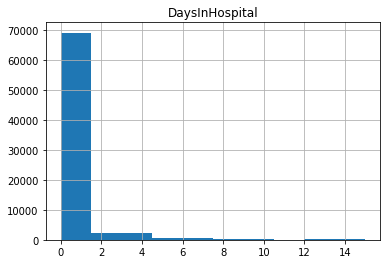

In [26]:
dihy2_df.hist("DaysInHospital")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110c0d2e8>]],
      dtype=object)

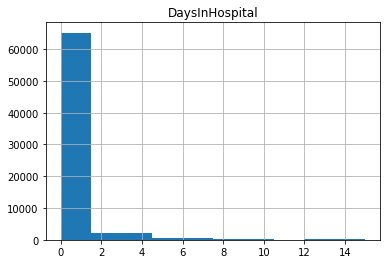

In [27]:
dihy3_df.hist("DaysInHospital")

#### Observations
1. About 76K members out of 110K total members have DIH records for Y2
2. There is only one record per year per member
3. Maximum people have spent 0 or 1 days in the hospital but there are few people who have even spent upto 14 days

## Create Base Model by just calculating Average/Mean

### Create flat table by combining all datasets

In [28]:
#First combine all datasets
#Need something like this: 
#MemberID|LabCountY1|LabCountY2|LabCountY3|
#DrugCountY1|DrugCountY2|DrugCountY3
#NumberOfClaimsY2|DaysInHospY2|
#NumberOfClaisY3|DaysInHospY3

#First fix several string-int inssues
lab_df1 = lab_df.replace("10+", "11")
drug_df1 = drug_df.replace("7+", "8")

#Lab Summary
lab_summary_df = pysqldf("SELECT sum(LabCount) as TotalLabCount, MemberID, Year \
        FROM lab_df1 group by MemberID, Year \
        ORDER BY TotalLabCount DESC;")

drug_summary_df = pysqldf("SELECT sum(DrugCount) as TotalDrugCount, MemberID, Year \
        FROM drug_df1 group by MemberID, Year \
        ORDER BY TotalDrugCount DESC;")

In [29]:
lab_summary_pivot = lab_summary_df.pivot(index='MemberID', columns='Year', values='TotalLabCount')
drug_summary_pivot = drug_summary_df.pivot(index='MemberID', columns='Year', values='TotalDrugCount')

In [30]:
claims_summary_df = pysqldf("SELECT count(*) as TotalClaimCount, MemberID, Year \
        FROM claims_df group by MemberID, Year")

claims_summary_pivot = claims_summary_df.pivot(index='MemberID', columns='Year', values='TotalClaimCount')

In [31]:
ls_flat_df = lab_summary_pivot.rename(columns={"Y1": "LabsY1", "Y2": "LabsY2", "Y3": "LabsY3"})
ds_flat_df = drug_summary_pivot.rename(columns={"Y1": "DrugsY1", "Y2": "DrugsY2", "Y3": "DrugsY3"})
cs_flat_df = claims_summary_pivot.rename(columns={"Y1": "ClaimsY1", "Y2": "ClaimsY2", "Y3": "ClaimsY3"})
dihy2_flat_df = dihy2_df.rename(columns={"ClaimsTruncated":"ClaimsTruncatedY2","DaysInHospital":"DaysInHospitalY2"})
dihy3_flat_df = dihy3_df.rename(columns={"ClaimsTruncated":"ClaimsTruncatedY3","DaysInHospital":"DaysInHospitalY3"})

In [32]:
dihy2_flat_df.set_index("MemberID", inplace=True)
dihy3_flat_df.set_index("MemberID", inplace=True)

In [33]:
combined_df = dihy2_flat_df.join(dihy3_flat_df, on=None, how='outer', rsuffix="_1")
combined_df = combined_df.join(ls_flat_df, on=None, how='outer', rsuffix="_1")
combined_df = combined_df.join(ds_flat_df, on=None, how='outer', rsuffix="_1")
combined_df = combined_df.join(cs_flat_df, on=None, how='outer', rsuffix="_1")

In [34]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113000 entries, 4 to 99998824
Data columns (total 13 columns):
ClaimsTruncatedY2    76038 non-null float64
DaysInHospitalY2     76038 non-null float64
ClaimsTruncatedY3    71435 non-null float64
DaysInHospitalY3     71435 non-null float64
LabsY1               53227 non-null float64
LabsY2               51268 non-null float64
LabsY3               50439 non-null float64
DrugsY1              49838 non-null float64
DrugsY2              46212 non-null float64
DrugsY3              45521 non-null float64
ClaimsY1             76038 non-null float64
ClaimsY2             71435 non-null float64
ClaimsY3             70942 non-null float64
dtypes: float64(13)
memory usage: 12.1 MB


In [35]:
combined_df.fillna(value=0, inplace=True)
combined_df.head(2)

,ClaimsTruncatedY2,DaysInHospitalY2,ClaimsTruncatedY3,DaysInHospitalY3,LabsY1,LabsY2,LabsY3,DrugsY1,DrugsY2,DrugsY3,ClaimsY1,ClaimsY2,ClaimsY3
MemberID,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,0.0,0.0,0.0,0.0,2.0,1.0,1.0,5.0,0.0,5.0,8.0,6.0,4.0


### Check for any correlation
Check if any column corelated to DaysInHospitalY3

In [36]:
corr_matrix = combined_df.corr()
corr_matrix["DaysInHospitalY3"].sort_values(ascending=False)

DaysInHospitalY3     1.000000
ClaimsY3             0.272518
ClaimsY2             0.258791
LabsY2               0.209529
DrugsY2              0.203035
ClaimsTruncatedY3    0.187062
LabsY3               0.165824
DrugsY3              0.140501
ClaimsY1             0.135505
DrugsY1              0.133948
DaysInHospitalY2     0.127593
ClaimsTruncatedY2    0.113756
LabsY1               0.108348
Name: DaysInHospitalY3, dtype: float64

OBSERVATION:
It looks like DaysInHospotalY3 is best correlated with ClaimY3. However, we cannot use Y3 data for predicting Y3 days in hospital. So, lets use next best - ClaimsY2

/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a288341d0>,
      dtype=object)

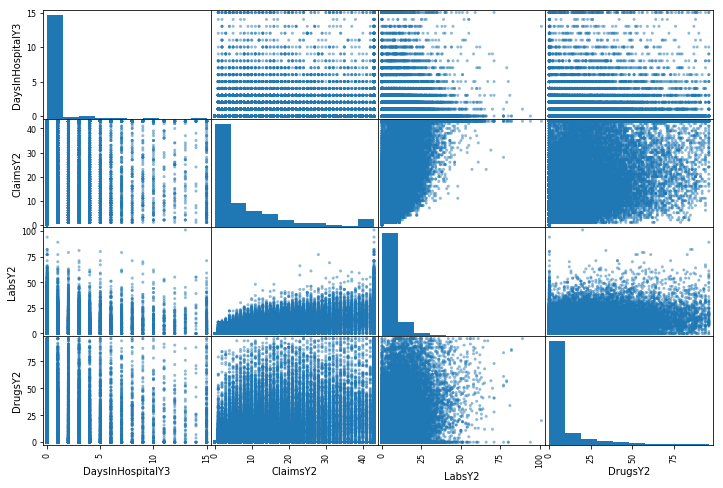

In [37]:
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
attributes = ["DaysInHospitalY3", "ClaimsY2", "LabsY2",
              "DrugsY2"]
scatter_matrix(combined_df[attributes], figsize=(12, 8))

NOTE: Since ClaimsY2 and DaysInHospitalY3 resonably corelate, lets use below strategy for basic prediction
1. Find different buckets for ClaimsY2
2. For each bucket, find mean of DaysInHospitalY3

In [38]:
import numpy as np
hist, bin_edges = np.histogram(combined_df["ClaimsY2"], density=True)
#combined_df['claimsy2_bucket'] = pd.cut(combined_df['ClaimsY2'], bins=bin_edges)
combined_df['claimsy2_bucket_idx'] = \
    pd.cut(combined_df['ClaimsY2'], bins=bin_edges, labels=False, include_lowest=True)
combined_df.head(10)

,ClaimsTruncatedY2,DaysInHospitalY2,ClaimsTruncatedY3,DaysInHospitalY3,LabsY1,LabsY2,LabsY3,DrugsY1,DrugsY2,DrugsY3,ClaimsY1,ClaimsY2,ClaimsY3,claimsy2_bucket_idx
MemberID,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
210,0.0,0.0,0.0,0.0,2.0,1.0,1.0,5.0,0.0,5.0,8.0,6.0,4.0,1
3197,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,3.0,6.0,5.0,5.0,11.0,1
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3713,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,17.0,0.0,0.0,10.0,0.0,2
3741,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,35.0,0.0,0.0,20.0,0.0,4
3889,0.0,0.0,0.0,0.0,11.0,0.0,0.0,30.0,0.0,0.0,13.0,0.0,0.0,0
4048,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,22.0,0
4187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,4.0,0.0,0.0,0


In [39]:
claims_dih_df = pysqldf("SELECT avg(DaysInHospitalY3) as AvgDIHY3, claimsy2_bucket_idx \
        FROM combined_df group by claimsy2_bucket_idx \
        ORDER BY claimsy2_bucket_idx ASC;")

In [40]:
claims_dih_df

,AvgDIHY3,claimsy2_bucket_idx
0,0.071960,0
1,0.276396,1
2,0.352283,2
3,0.470410,3
4,0.551025,4
5,0.621053,5
6,0.706621,6
7,0.888673,7
8,0.933988,8
9,1.368167,9


Now assign the value of AvgDIHY3 back to combined_df

In [41]:
#combined_avg_df = combined_df.join(claims_dih_df, on="claimsy2_bucket_idx", how='inner', rsuffix="_1")
combined_avg_df = pysqldf("SELECT *  \
        FROM combined_df cd INNER JOIN  claims_dih_df cl \
        ON(cd.claimsy2_bucket_idx = cl.claimsy2_bucket_idx) \
        ")
combined_avg_df.set_index("MemberID", inplace=True)
combined_avg_df

,ClaimsTruncatedY2,DaysInHospitalY2,ClaimsTruncatedY3,DaysInHospitalY3,LabsY1,LabsY2,LabsY3,DrugsY1,DrugsY2,DrugsY3,ClaimsY1,ClaimsY2,ClaimsY3,claimsy2_bucket_idx,AvgDIHY3,claimsy2_bucket_idx
MemberID,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.071960,0
210,0.0,0.0,0.0,0.0,2.0,1.0,1.0,5.0,0.0,5.0,8.0,6.0,4.0,1,0.276396,1
3197,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,3.0,6.0,5.0,5.0,11.0,1,0.276396,1
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.071960,0
3713,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,17.0,0.0,0.0,10.0,0.0,2,0.352283,2
3741,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,35.0,0.0,0.0,20.0,0.0,4,0.551025,4
3889,0.0,0.0,0.0,0.0,11.0,0.0,0.0,30.0,0.0,0.0,13.0,0.0,0.0,0,0.071960,0
4048,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,22.0,0,0.071960,0
4187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,4.0,0.0,0.0,0,0.071960,0


### Split the Target Data and Hide it out
The original Kaggle completition had Target.csv which contain the member_ids. The  task was to predict the days_in_hospital for those member_ids. However, since the competition is closed now, we cannot verify our predictions. So, create our own Target (Y2 and Y3) by splitting the dih_y2 and dih_y3.

In [42]:
from sklearn.model_selection import train_test_split
#First divide DaysInHospital data in train and test 
dihy3_y = dihy3_flat_df["DaysInHospitalY3"].copy()
dihy3_X = dihy3_flat_df.drop("DaysInHospitalY3", axis=1) # drop labels for training set

dihy3_X_train, dihy3_X_test, dihy3_ytrain, dihy3_ytest = \
                            train_test_split(dihy3_X, dihy3_y, test_size=0.33, random_state=42)
print("X_train shape: ", dihy3_X_train.shape)
print("X_test shape: ", dihy3_X_test.shape)
print("y_train shape: ", dihy3_ytrain.shape)
print("y_test shape: ", dihy3_ytest.shape)

#Then take inner join with combined_avg_df so that we only get train MemberID in train set 
#and test MemberID in test set
combined_avg_df1_X_test = dihy3_X_test.join(combined_avg_df, on=None, how="inner", rsuffix="_2")
combined_avg_df1_X_train = dihy3_X_train.join(combined_avg_df, on=None, how="inner", rsuffix="_2")

X_train shape:  (47861, 1)
X_test shape:  (23574, 1)
y_train shape:  (47861,)
y_test shape:  (23574,)


Our combined_avg_df1_X_test already have prediction column (AvgDIHY3). Lets see how much is the error.

### Calculate Error
The HHP prediction accuracy measure is the log root-mean-squared-error (log RMSE) loss function

e=((sum(square(log(pi+1)−log(ai+1)])))/n
 
where

i: is a member

n: is the total number of members

pi: is the predicted number of days spent in the hospital for member i in the test period

ai: is the actual number of days spent in the hospital for member  i in the test period.

In [43]:
from sklearn.metrics import mean_squared_error
def calc_error(actual, predictions):
    return(np.mean(np.square(np.log(predictions+1) - np.log(actual+1))))
def calc_rmse(actual, predictions):
    mse = mean_squared_error(actual, predictions)
    return(np.sqrt(mse))

In [44]:
predict_avg = np.floor(combined_avg_df1_X_test["AvgDIHY3"])
error_avg = calc_error(dihy3_ytest, predict_avg)
rmse_avg = calc_rmse(dihy3_ytest, predict_avg)
print("Error = ", error_avg)
print("RMSE = ", rmse_avg)

Error =  0.2436542912261619
RMSE =  1.5413890511508508


In [45]:
pairwise = zip (dihy3_ytest, predict_avg)
matched = [idx for idx, pair in enumerate(pairwise) if pair[0] == pair[1]]

In [46]:
accurate = len(matched)
total = len(predict_avg)
print("Accurate = ", accurate, " total = ", total, "precentage = ", accurate*100/total)

Accurate =  19058  total =  23574 precentage =  80.84330194281836


OK. So, we have very basic model which is not machine learning based and base error coming out of it. Lets try machine learning model. 

## Create first Machine Learning Model
Lets try out RandomForest since it generally works as a base model

### Create pipeline
Lets consider only numerical inputs for now

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_attribs = ["ClaimsTruncatedY2", "DaysInHospitalY2", 
               "LabsY1","LabsY2",
               "DrugsY1","DrugsY2",
               "ClaimsY1","ClaimsY2"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

X_train_prepared = num_pipeline.fit_transform(combined_avg_df1_X_train)

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

if __avoid_run_heavy_tasks__ == False:
    param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    forest_reg = RandomForestRegressor(random_state=42)
    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
    grid_search.fit(X_train_prepared, dihy3_ytrain)
    print(grid_search.best_estimator_)
    
    cvres = grid_search.cv_results_
    for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(accuracy, params)

In [50]:
#final_model = grid_search.best_estimator_
final_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
final_model.fit(X_train_prepared, dihy3_ytrain)

X_test_prepared = num_pipeline.transform(combined_avg_df1_X_test)
predict_base_rf = final_model.predict(X_test_prepared)
predict_base_rf = np.floor(predict_base_rf)
error_base_rf = calc_error(dihy3_ytest, predict_base_rf)
rmse_base_rf = calc_rmse(dihy3_ytest, predict_base_rf)
print("Error = ", error_base_rf)
print("RMSE = ", rmse_base_rf)


Error =  0.2717722908121741
RMSE =  1.559120273688745


In [51]:
pairwise = zip (dihy3_ytest, predict_base_rf)
matched = [idx for idx, pair in enumerate(pairwise) if pair[0] == pair[1]]
accurate = len(matched)
total = len(predict_avg)
print("Accurate = ", accurate, " total = ", total, "precentage = ", accurate*100/total)

Accurate =  18003  total =  23574 precentage =  76.36803257826419


In [52]:
kFolds = 10
corss_val_base_rf = cross_val_score(final_model, X_train_prepared.astype(np.float32), \
                             dihy3_ytrain,
                             scoring="neg_mean_squared_error", cv=kFolds)
corss_val_base_rf

array([-2.45243823, -2.61456451, -2.89964008, -2.23455588, -2.38395185,
       -1.95808435, -2.56335282, -2.62674591, -2.30292151, -2.38951638])

<b>Summary</b>
Error of ML base model is close to basic "average" based model. Next step is to do feature engineering to improve the accuracy. 

## Reporting

In [53]:
results_table = pd.DataFrame(columns=["Experiment", "Error (Test)", "RMSE (Test)", 
                                "cross_val_scores", "p_value", "t_score", "Experiment description", ])
results_table.loc[len(results_table)] = ["Simple logic based on finding Average for DIH", 
                             error_avg, rmse_avg,
                             [],"not calculated", "not calculated",  
                             'The mean value of DIH is calculated based on histogram of number of claims in y2']
results_table.loc[len(results_table)] = ["Random Forest", 
                             error_base_rf, rmse_base_rf,
                              corss_val_base_rf,"not calculated", "not calculated",  
                             'Only numeric fields which are directly available in claims, labs and drugs table are used as features']
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,Experiment description
0,Simple logic based on finding Average for DIH,0.243654,1.541389,not calculated,not calculated,The mean value of DIH is calculated based on h...
1,Random Forest,0.271772,1.559120,not calculated,not calculated,Only numeric fields which are directly availab...


# Phase 2

## Feature Engineering
In the basic pipeline, we have used very few attributes of the data. Lets analyze all the different data fields that are available. 

### Claims Data - Cleanup numeric values represented as range
LengthOfStay, DSFS and CharlsonIndex are numeric values but stored as range. Lets separate out Min and Max values in separate columns

In [54]:
claims_df.head(2)

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
1,97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0


In [55]:
#Cleanup the numerical columns first
#DSFS - DSFSMin, DSFSMax
#CharlsonIndex - CharlsonIndexMin, CharlsonIndexMax

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

def dsfs_min(strdsfs):
    try:
        if len(strdsfs) > 0:
            strdsfs = strdsfs.replace("months", "")
            strdsfs = strdsfs.replace("month", "")
            parts = strdsfs.split("-")
            parts = [ int(x) for x in parts ]
            return parts[0]
        else:
            return(0)
    except:
        return(0)
    
def dsfs_max(strdsfs):
    try:
        if len(strdsfs) > 0:
            strdsfs = strdsfs.replace("months", "")
            strdsfs = strdsfs.replace("month", "")
            parts = strdsfs.split("-")
            parts = [ int(x) for x in parts ]
            return parts[1]
        else:
            return(0)
    except:
        return(0)
    
def CharlsonIndex_min(strc):
    try:
        if len(strdsfs) > 0:
            parts = strc.split("-")
            parts = [ int(x) for x in parts ]
            return parts[0]
        else:
            return(0)
    except:
        return(0)

def CharlsonIndex_max(strc):
    try:
        if len(strc) > 0:
            parts = strc.split("-")
            if len(parts) > 1:
                return int(parts[1])
            else:
                return 0
        else:
            return(0)
    except:
        return(0)


#apply_and_concat(claims_df, 'DSFS', dsfs_min_max, ['DSFSMin', 'DSFSMax'])

claims_df["DSFSMin"] = claims_df['DSFS'].apply(dsfs_min)
claims_df["DSFSMax"] = claims_df['DSFS'].apply(dsfs_max)
claims_df["CharlsonIndexMin"] = claims_df['CharlsonIndex'].apply(CharlsonIndex_min)
claims_df["CharlsonIndexMax"] = claims_df['CharlsonIndex'].apply(CharlsonIndex_max)


In [56]:
claims_df["LengthOfStay"].unique()

array([nan, '1 day', '2- 4 weeks', '2 days', '3 days', '4 days',
       '1- 2 weeks', '4- 8 weeks', '6 days', '5 days', '26+ weeks'],
      dtype=object)

In [57]:
def LengthOfStay_max(strc):
    if strc == "1 day":
        return 1
    elif strc == "2- 4 weeks":
        return 4 * 7
    elif strc == "2 days":
        return 2
    elif strc == "3 days":
        return 3
    elif strc == "4 days":
        return 4
    elif strc == "1- 2 weeks":
        return 14
    elif strc == "4- 8 weeks":
        return 56
    elif strc == "6 days":
        return 6
    elif strc == "5 days":
        return 5
    elif strc == "26+ weeks":
        return 30*7
    return 0

def LengthOfStay_min(strc):
    if strc == "1 day":
        return 1
    elif strc == "2- 4 weeks":
        return 2 * 7
    elif strc == "2 days":
        return 2
    elif strc == "3 days":
        return 3
    elif strc == "4 days":
        return 4
    elif strc == "1- 2 weeks":
        return 7
    elif strc == "4- 8 weeks":
        return 28
    elif strc == "6 days":
        return 6
    elif strc == "5 days":
        return 5
    elif strc == "26+ weeks":
        return 26*7
    return 0

In [58]:
claims_df["LengthOfStayMin"] = claims_df['LengthOfStay'].apply(LengthOfStay_min)
claims_df["LengthOfStayMax"] = claims_df['LengthOfStay'].apply(LengthOfStay_max)

In [59]:
claims_df.head(5)

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS,DSFSMin,DSFSMax,CharlsonIndexMin,CharlsonIndexMax,LengthOfStayMin,LengthOfStayMax
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0,8,9,0,0,0,0
1,97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0,7,8,0,2,0,0
2,2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0,0,1,0,0,0,0
3,73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0,5,6,0,2,0,0
4,11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0,4,5,0,2,0,0


### Claims Data - Categorical Columns and One Hot Encoding
Lets use simple SQL to convert categorical values into individual column and also sum them up by MemberID and Year

In [60]:
#Lets find distinct values of Specialty, PlaceSvc, DSFS, 
#PrimaryConditionGroup, CharlsOnIndex, ProcedureGroup
cat_cols = ["Specialty", "PlaceSvc", "PrimaryConditionGroup", "ProcedureGroup"]
unique_vals = dict()
for cat_col in cat_cols:
    unique_vals[cat_col] = claims_df[cat_col].unique()
    print(cat_col, ":", unique_vals[cat_col])


Specialty : ['Surgery' 'Internal' 'Laboratory' 'Pediatrics' 'Rehabilitation'
 'Diagnostic Imaging' 'Anesthesiology' 'Emergency' 'General Practice'
 'Other' 'Obstetrics and Gynecology' 'Pathology' nan]
PlaceSvc : ['Office' 'Independent Lab' 'Outpatient Hospital' 'Inpatient Hospital'
 'Urgent Care' 'Ambulance' 'Home' nan 'Other']
PrimaryConditionGroup : ['NEUMENT' 'METAB3' 'FXDISLC' 'TRAUMA' 'RESPR4' 'INFEC4' 'MISCHRT'
 'ARTHSPIN' 'ROAMI' 'HEART2' 'MSC2a3' 'PNEUM' 'MISCL5' 'GIOBSENT' 'RENAL3'
 'GYNEC1' 'AMI' 'UTI' 'COPD' 'GIBLEED' 'HIPFX' 'SKNAUT' 'CANCRB' 'SEIZURE'
 'CHF' 'PRGNCY' 'METAB1' 'HEART4' 'ODaBNCA' 'HEMTOL' 'GYNECA' 'APPCHOL'
 'MISCL1' 'RENAL2' nan 'STROKE' 'PERVALV' 'CANCRA' 'CATAST' 'FLaELEC'
 'SEPSIS' 'LIVERDZ' 'PNCRDZ' 'RENAL1' 'CANCRM' 'PERINTL']
ProcedureGroup : ['MED' 'EM' 'SCS' 'RAD' 'ANES' 'SDS' 'PL' 'SIS' 'SMS' 'SGS' 'SEOA' 'SNS'
 nan 'SAS' 'SRS' 'SUS' 'SO' 'SMCD']


<B>One hot Encoding using SQL - </B>
Generage Query like below:

sum(case when Specialty = 'Surgery' then 1 else 0 end) as spl_surgery, \
sum(case when Specialty = 'Internal' then 1 else 0 end) as spl_internal
                              

In [61]:
sql = []
for cat_col in cat_cols:
    cat_sql = []
    for unique_value in unique_vals[cat_col]:
        unique_value = str(unique_value).replace(" ", "")
        col_name = cat_col + "_" + str(unique_value)
        cat_sql.append("SUM(CASE WHEN " + cat_col + " = '" + unique_value + "' THEN 1 ELSE 0 END) AS " + col_name )
    sql.append(','.join(cat_sql))
strsql = ','.join(sql)

num_sql = "SELECT MemberID, Year, \
COUNT(DISTINCT ProviderID) as ProviderCount, \
COUNT(DISTINCT Vendor) as VendorCount, \
MIN(PCP) as MinPCP, MAX(PCP) as MaxPCP, AVG(PCP) as AvgPCP, \
MIN(LengthOfStayMin) as MinLengthOfStayMin, MAX(LengthOfStayMin) as MaxLengthOfStayMin, AVG(LengthOfStayMin) as AvgLengthOfStayMin,\
MIN(LengthOfStayMax) as MinLengthOfStayMax, MAX(LengthOfStayMax) as MaxLengthOfStayMax, AVG(LengthOfStayMax) as AvgLengthOfStayMax,\
MIN(DSFSMin) as MinDSFSMin, MAX(DSFSMin) as MaxDSFSMin, AVG(DSFSMin) as AvgDSFSMin,\
MIN(DSFSMax) as MinDSFSMax, MAX(DSFSMax) as MaxDSFSMax, AVG(DSFSMax) as AvgDSFSMax,\
MIN(CharlsonIndexMin) as MinCharlsonIndexMin, MAX(CharlsonIndexMin) as MaxCharlsonIndexMin, AVG(CharlsonIndexMin) as AvgCharlsonIndexMin,\
MIN(CharlsonIndexMax) as MinCharlsonIndexMax, MAX(CharlsonIndexMax) as MaxCharlsonIndexMax, AVG(CharlsonIndexMax) as AvgCharlsonIndexMax \
"


complete_sql = num_sql + "," + strsql + " FROM claims_df cd GROUP BY MemberID, Year"
print(complete_sql)

SELECT MemberID, Year, COUNT(DISTINCT ProviderID) as ProviderCount, COUNT(DISTINCT Vendor) as VendorCount, MIN(PCP) as MinPCP, MAX(PCP) as MaxPCP, AVG(PCP) as AvgPCP, MIN(LengthOfStayMin) as MinLengthOfStayMin, MAX(LengthOfStayMin) as MaxLengthOfStayMin, AVG(LengthOfStayMin) as AvgLengthOfStayMin,MIN(LengthOfStayMax) as MinLengthOfStayMax, MAX(LengthOfStayMax) as MaxLengthOfStayMax, AVG(LengthOfStayMax) as AvgLengthOfStayMax,MIN(DSFSMin) as MinDSFSMin, MAX(DSFSMin) as MaxDSFSMin, AVG(DSFSMin) as AvgDSFSMin,MIN(DSFSMax) as MinDSFSMax, MAX(DSFSMax) as MaxDSFSMax, AVG(DSFSMax) as AvgDSFSMax,MIN(CharlsonIndexMin) as MinCharlsonIndexMin, MAX(CharlsonIndexMin) as MaxCharlsonIndexMin, AVG(CharlsonIndexMin) as AvgCharlsonIndexMin,MIN(CharlsonIndexMax) as MinCharlsonIndexMax, MAX(CharlsonIndexMax) as MaxCharlsonIndexMax, AVG(CharlsonIndexMax) as AvgCharlsonIndexMax ,SUM(CASE WHEN Specialty = 'Surgery' THEN 1 ELSE 0 END) AS Specialty_Surgery,SUM(CASE WHEN Specialty = 'Internal' THEN 1 ELSE 0 END

In [62]:
summary_claims_df = pysqldf(complete_sql)

In [63]:
summary_claims_df.head(5)

,MemberID,Year,ProviderCount,VendorCount,MinPCP,MaxPCP,AvgPCP,MinLengthOfStayMin,MaxLengthOfStayMin,AvgLengthOfStayMin,...,ProcedureGroup_SMS,ProcedureGroup_SGS,ProcedureGroup_SEOA,ProcedureGroup_SNS,ProcedureGroup_nan,ProcedureGroup_SAS,ProcedureGroup_SRS,ProcedureGroup_SUS,ProcedureGroup_SO,ProcedureGroup_SMCD
0,4,Y2,1,1,31106.0,31106.0,31106.0,0,0,0.00,...,0,0,0,0,0,0,0,0,0,0
1,210,Y1,4,4,18880.0,37508.0,35179.5,0,2,0.25,...,0,0,0,0,0,0,0,0,0,0
2,210,Y2,3,3,37508.0,37508.0,37508.0,0,0,0.00,...,0,0,0,0,0,0,0,0,0,0
3,210,Y3,2,2,37508.0,37508.0,37508.0,0,0,0.00,...,0,0,0,0,0,0,0,0,0,0
4,3197,Y1,3,3,47016.0,47016.0,47016.0,0,0,0.00,...,0,0,0,0,0,0,0,0,0,0


In [64]:
summary_claims_df.shape


(218415, 111)

### Members Table - Similar Cleanup

In [65]:
#Lets cleanup members table
members_df["AgeAtFirstClaim"].unique()


array(['70-79', '40-49', '0-9', '30-39', '50-59', '60-69', '10-19', '80+',
       '20-29', nan], dtype=object)

In [66]:
def AgeAtFirstClaim_max(strc):
    try:
        if len(strc) > 0:
            parts = strc.split("-")
            if len(parts) > 1:
                return int(parts[1])
            else:
                return 0
        else:
            return(0)
    except:
        return(0)

def AgeAtFirstClaim_min(strc):
    try:
        if len(strc) > 0:
            parts = strc.split("-")
            return int(parts[0])
        else:
            return(0)
    except:
        return(0)
    
#apply_and_concat(claims_df, 'DSFS', dsfs_min_max, ['DSFSMin', 'DSFSMax'])

members_df["AgeAtFirstClaimMin"] = members_df['AgeAtFirstClaim'].apply(AgeAtFirstClaim_min)
members_df["AgeAtFirstClaimMax"] = members_df['AgeAtFirstClaim'].apply(AgeAtFirstClaim_max)

### Combine All Tables 
All Tables can be indexed using MemberID-Year now and then can be combined

In [67]:
#Combine lab_summary_df, drug_summary_df, summary_claims_df,dihy2_df, dihy3_df 
#All above dataframes can be indexed on MembedID and Yera
#lab_summary_df.set_index(["MemberID", "Year"], inplace=True)
#drug_summary_df.set_index(["MemberID", "Year"], inplace=True)
summary_claims_df.set_index(["MemberID", "Year"], inplace=True)


In [68]:
#year2 days in hospital is target for year 1
dihy2_df["Year"] = "Y1"
dihy2_df.set_index(["MemberID", "Year"], inplace=True)
#year3 days in hospital is target for year 1
dihy3_df["Year"] = "Y2"
dihy3_df.set_index(["MemberID", "Year"], inplace=True)

In [69]:
lab_summary_df.set_index(["MemberID", "Year"], inplace=True)
drug_summary_df.set_index(["MemberID", "Year"], inplace=True)

In [70]:
#summary_df = dihy2_df.union(dihy3_df, on=None, how='outer')
summary_df = pd.concat([dihy2_df, dihy3_df])
summary_df = summary_df.join(lab_summary_df, on=None, how='outer')
summary_df = summary_df.join(drug_summary_df, on=None, how='outer')
summary_df = summary_df.join(summary_claims_df, on=None, how='outer')

In [71]:
print("summary_df.shape = ", summary_df.shape)
print("lab_summary_df.shape = ", lab_summary_df.shape)
print("summary_claims_df.shape = ", summary_claims_df.shape)


summary_df.shape =  (218415, 113)
lab_summary_df.shape =  (154934, 1)
summary_claims_df.shape =  (218415, 109)


In [72]:
summary_df.index.get_level_values('MemberID').unique()

Int64Index([       4,      210,     3197,     3457,     3713,     3741,
                3889,     4048,     4187,     5187,
            ...
            99992565, 99993334, 99994536, 99995391, 99995554, 99996214,
            99997485, 99997895, 99998627, 99998824],
           dtype='int64', name='MemberID', length=113000)

In [73]:
members_df.MemberID.count()

113000

In [74]:
summary_df_m = summary_df.reset_index()
summary_df_m.set_index("MemberID", inplace=True)

In [75]:
members_df.set_index("MemberID", inplace=True)
members_df.head(2)

,AgeAtFirstClaim,Sex,AgeAtFirstClaimMin,AgeAtFirstClaimMax
MemberID,,,,
14723353,70-79,M,70,79
75706636,70-79,M,70,79


In [76]:
summary_df_m = summary_df_m.join(members_df, on=None, how='outer')

In [77]:
summary_df_m.shape

(218415, 118)

In [78]:
summary_df_m.head(2)

,Year,ClaimsTruncated,DaysInHospital,TotalLabCount,TotalDrugCount,ProviderCount,VendorCount,MinPCP,MaxPCP,AvgPCP,...,ProcedureGroup_nan,ProcedureGroup_SAS,ProcedureGroup_SRS,ProcedureGroup_SUS,ProcedureGroup_SO,ProcedureGroup_SMCD,AgeAtFirstClaim,Sex,AgeAtFirstClaimMin,AgeAtFirstClaimMax
MemberID,,,,,,,,,,,,,,,,,,,,,
4,Y2,0.0,0.0,NaN,NaN,1,1,31106.0,31106.0,31106.0,...,0,0,0,0,0,0,0-9,M,0,9
210,Y1,0.0,0.0,2.0,5.0,4,4,18880.0,37508.0,35179.5,...,0,0,0,0,0,0,30-39,NaN,30,39


### Make sure we have not lost any Member data

In [79]:
summary_df_m.index.get_level_values('MemberID').unique()

Int64Index([       4,      210,     3197,     3457,     3713,     3741,
                3889,     4048,     4187,     5187,
            ...
            99992565, 99993334, 99994536, 99995391, 99995554, 99996214,
            99997485, 99997895, 99998627, 99998824],
           dtype='int64', name='MemberID', length=113000)

In [80]:
members_df.index.get_level_values("MemberID").unique()

Int64Index([14723353, 75706636, 17320609, 69690888, 33004608, 63690883,
            50065607, 34270657, 75299016, 22358692,
            ...
            21382846, 29024181, 90655054,   735535, 10486927, 99711514,
            31690877,  9519985, 92806272, 81827173],
           dtype='int64', name='MemberID', length=113000)

<B>Summary </B> Observe that both tables have same number of Members. So, we are good

In [81]:
#Write down the prepared DF to disk so that we can simply start from his point
summary_df_m.to_csv(data_path + "summary_df.csv")

In [82]:
summary_df_m = pd.read_csv(data_path + "summary_df.csv")

In [83]:
summary_df_m["Year"].unique()

array(['Y2', 'Y1', 'Y3'], dtype=object)

## Drop Y3 data
We do not have predictions available for Y4. And unlike real competation, we can't submit Y4 predictions to the kaggle and get our score. So, there is no point in using Y3 data for training. So drop it.

In [84]:
summary_df_m = (summary_df_m[summary_df_m["Year"] != "Y3"])

## Split the Target Data and Hide it out

In [85]:
#If DaysInHospital is missing, mark it 0
summary_df_m["DaysInHospital"].fillna(0, inplace=True)
summary_df_m["DaysInHospital"].count()

147473

In [86]:
from sklearn.model_selection import train_test_split
#First divide DaysInHospital data in train and test 
y = summary_df_m["DaysInHospital"].copy()
X = summary_df_m.drop("DaysInHospital", axis=1) # drop labels for training set

#Drop unnecessary columns

X.drop("AgeAtFirstClaim", inplace=True, axis=1)
X.drop("Sex", inplace=True, axis=1) #check if we need this
'''
X.drop("PCP", inplace=True, axis=1)
X.drop("LengthOfStay", inplace=True, axis=1)
X.drop("DSFS", inplace=True, axis=1)
X.drop("CharlsonIndex", inplace=True, axis=1)
'''

X_train, X_test, y_train, y_test = \
                            train_test_split(X, y, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (98806, 116)
X_test shape:  (48667, 116)
y_train shape:  (98806,)
y_test shape:  (48667,)


In [87]:
#Drop unnecessary columns
summary_df_m.shape

(147473, 119)

## Create Pipeline for Data Preperation

In [88]:
num_columns = list(X_train.columns.values)
num_columns.remove("Year")
num_columns

['MemberID',
 'ClaimsTruncated',
 'TotalLabCount',
 'TotalDrugCount',
 'ProviderCount',
 'VendorCount',
 'MinPCP',
 'MaxPCP',
 'AvgPCP',
 'MinLengthOfStayMin',
 'MaxLengthOfStayMin',
 'AvgLengthOfStayMin',
 'MinLengthOfStayMax',
 'MaxLengthOfStayMax',
 'AvgLengthOfStayMax',
 'MinDSFSMin',
 'MaxDSFSMin',
 'AvgDSFSMin',
 'MinDSFSMax',
 'MaxDSFSMax',
 'AvgDSFSMax',
 'MinCharlsonIndexMin',
 'MaxCharlsonIndexMin',
 'AvgCharlsonIndexMin',
 'MinCharlsonIndexMax',
 'MaxCharlsonIndexMax',
 'AvgCharlsonIndexMax',
 'Specialty_Surgery',
 'Specialty_Internal',
 'Specialty_Laboratory',
 'Specialty_Pediatrics',
 'Specialty_Rehabilitation',
 'Specialty_DiagnosticImaging',
 'Specialty_Anesthesiology',
 'Specialty_Emergency',
 'Specialty_GeneralPractice',
 'Specialty_Other',
 'Specialty_ObstetricsandGynecology',
 'Specialty_Pathology',
 'Specialty_nan',
 'PlaceSvc_Office',
 'PlaceSvc_IndependentLab',
 'PlaceSvc_OutpatientHospital',
 'PlaceSvc_InpatientHospital',
 'PlaceSvc_UrgentCare',
 'PlaceSvc_Ambula

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_attribs = num_columns #all columns are numeric now

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

X_train_prepared = num_pipeline.fit_transform(X_train)
X_test_prepared = num_pipeline.fit_transform(X_test)

## Try out Multiple Machine Learning Models

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

if __avoid_run_heavy_tasks__ == False:
    models = []
    models.append(('LINEAR', LinearRegression()))
    #models.append(('LR', LogisticRegression()))
    models.append(('NB', GaussianNB()))
    if __avoid_run_svm__ == False:
        models.append(('SVM', SVR()))
    models.append(('RandomForest', RandomForestRegressor()))

    agg_results = []
    names = []
    scoring = 'neg_mean_squared_error'
    for name, model in models:
        kfold = KFold(n_splits=5, random_state=7)
        #cv_results = cross_val_score(model, X_train_prepared[:1000,:], y_train[:1000], cv=kfold, scoring=scoring)
        if __name__ == "__main__":    
            cv_results = cross_val_score(model, X_train_prepared[:50000,:], y_train[:50000], cv=kfold, scoring=scoring, n_jobs=-1)
        agg_results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)


<b>Summary</b>
The Linear, SVM and RanfomForest seem to perform equally well. Notice that we did this experiment on about 40% of the data and Negative RMSE was used as measure. Lets pick up SVM and Random Forest and score them on held out dataset. 

In [91]:
from sklearn.ensemble import RandomForestRegressor
#rf_final_model = grid_search.best_estimator_
lin_final_model = LinearRegression()
lin_final_model.fit(X_train_prepared, y_train)

predict_lin = np.floor(lin_final_model.predict(X_test_prepared))
error_lin = calc_error(y_test, predict_lin)
rmse_lin = calc_rmse(y_test, predict_lin)
print("Error = ", error_lin)
print("RMSE = ", rmse_lin)

Error =  inf
RMSE =  1.5815708738457035


/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


## Hyper-parameter tuning for Random Forest

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

if __avoid_run_heavy_tasks__ == False:

    param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    forest_reg = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
    #grid_search.fit(X_train_prepared[:1000,:], y_train[:1000])
    grid_search.fit(X_train_prepared, y_train)
    print(grid_search.best_estimator_)

In [93]:
from sklearn.ensemble import RandomForestRegressor
#rf_final_model = grid_search.best_estimator_
rf_final_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
rf_final_model.fit(X_train_prepared, y_train)

predict_rf = rf_final_model.predict(X_test_prepared)
predict_rf = np.floor(predict_rf)
error_rf = calc_error(y_test, predict_rf)
rmse_rf = calc_rmse(y_test, predict_rf)
print("Error = ", error_rf)
print("RMSE = ", rmse_rf)
error_rf

Error =  0.25479374541837824
RMSE =  1.5738346918562176


0.25479374541837824

In [94]:
kFolds = 10
corss_val_rf = cross_val_score(rf_final_model, X_train_prepared.astype(np.float32), \
                             y_train,
                             scoring="neg_mean_squared_error", cv=kFolds)
corss_val_rf

array([-2.27601106, -2.3975855 , -2.3617343 , -2.37683042, -2.12574505,
       -2.48326028, -2.50439568, -2.33549382, -2.41254361, -2.30833293])

In [95]:
results_table.loc[len(results_table)] = ["Random Forest - After Feature Engineering", 
                             error_rf, rmse_rf,
                              corss_val_rf,"not calculated", "not calculated",  
                             'Feature Engineering, Parameter Tuning']
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,Experiment description
0,Simple logic based on finding Average for DIH,0.243654,1.541389,not calculated,not calculated,The mean value of DIH is calculated based on h...
1,Random Forest,0.271772,1.559120,not calculated,not calculated,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.254794,1.573835,not calculated,not calculated,"Feature Engineering, Parameter Tuning"


## Hyper-parameter tuning for SVM
Lets try Random Search instead of Grid Search this time around.
Since SVM training takes long time, using only partial dataset (about 1/3 size)

In [96]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

if __avoid_run_svm__ == False:
    param_distributions = {"gamma": reciprocal(0.001, 0.5), "C": uniform(2, 10)}
    rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42,  n_jobs=-1)
    if __name__ == "__main__":     
        rnd_search_cv.fit(X_train_prepared[:40000,:], y_train[:40000])
        #rnd_search_cv.fit(X_train_prepared, y_train)
    rnd_search_cv.best_estimator_

In [97]:
if __avoid_run_svm__ == False:
    #best_svr = rnd_search_cv.best_estimator_
    best_svr = SVR(C=10.324426408004218, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
      gamma=0.003741940611118496, kernel='rbf', max_iter=-1, shrinking=True,
      tol=0.001, verbose=False)

    best_svr.fit(X_train_prepared[:40000,:], y_train[:40000])

    predict_svr = best_svr.predict(X_test_prepared)
    predict_svr = np.floor(predict_svr)
    error_svr = calc_error(y_test, predict_svr)
    error_svr

In [98]:
if __avoid_run_svm__ == False:
    rmse_svr = calc_rmse(y_test, predict_svr)
    print("RMSE = ", rmse_svr)

In [99]:
if __avoid_run_svm__ == False:
    kFolds = 10
    corss_val_svr = cross_val_score(best_svr, X_train_prepared.astype(np.float32), \
                                 y_train,
                                 scoring="neg_mean_squared_error", cv=kFolds)
    corss_val_svr

In [100]:
if __avoid_run_svm__ == False:
    results_table.loc[len(results_table)] = ["SVM(SVR) - After Feature Engineering", 
                                 "Divide by 0 error", rmse_svr,
                                  corss_val_svr,"not calculated", "not calculated",  
                                 'Feature Engineering, Parameter Tuning']
else:
    results_table.loc[len(results_table)] = ["SVM(SVR) - After Feature Engineering", 
                                 "Divide by 0 error", 1.6519,
                                  [],"not calculated", "not calculated",  
                                 'Feature Engineering, Parameter Tuning']
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,Experiment description
0,Simple logic based on finding Average for DIH,0.243654,1.541389,not calculated,not calculated,The mean value of DIH is calculated based on h...
1,Random Forest,0.271772,1.559120,not calculated,not calculated,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.254794,1.573835,not calculated,not calculated,"Feature Engineering, Parameter Tuning"
3,SVM(SVR) - After Feature Engineering,Divide by 0 error,1.651900,not calculated,not calculated,"Feature Engineering, Parameter Tuning"


## Full Pipeline - Random Forest

In [101]:
#Create Full Prediction Pipeline
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rf)
    ])

full_pipeline_with_predictor.fit(X_train, y_train)
predict_full = full_pipeline_with_predictor.predict(X_test)
error_rf_full = calc_error(y_test, predict_full)
rmse_rf_full = calc_rmse(y_test, predict_full)
print("Error = ", error_rf_full)
print("RMSE = ", rmse_rf_full)

Error =  0.2726796902622541
RMSE =  1.542195163645455


In [102]:
kFolds = 10
corss_val_rf_full = cross_val_score(full_pipeline_with_predictor, X_train, \
                             y_train,
                             scoring="neg_mean_squared_error", cv=kFolds)
corss_val_rf_full

array([-2.27811791, -2.40004988, -2.36339248, -2.37533428, -2.12745296,
       -2.48034863, -2.50298475, -2.33430309, -2.41405295, -2.30921908])

In [103]:
results_table.loc[len(results_table)] = ["Random Forest - After Feature Engineering", 
                             error_rf_full, rmse_rf_full,
                             corss_val_rf_full,"not calculated", "not calculated",  
                             'Full Prediction Pipeline']
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,Experiment description
0,Simple logic based on finding Average for DIH,0.243654,1.541389,not calculated,not calculated,The mean value of DIH is calculated based on h...
1,Random Forest,0.271772,1.559120,not calculated,not calculated,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.254794,1.573835,not calculated,not calculated,"Feature Engineering, Parameter Tuning"
3,SVM(SVR) - After Feature Engineering,Divide by 0 error,1.651900,not calculated,not calculated,"Feature Engineering, Parameter Tuning"
4,Random Forest - After Feature Engineering,0.27268,1.542195,not calculated,not calculated,Full Prediction Pipeline


In [104]:
import numpy as np
np.mean(y_test)

0.4529763494770584

In [105]:
#Write down the Result DF to disk so that we can simply start from his point
results_table.to_csv(data_path + "result_table.csv")

In [106]:
results_table = pd.read_csv(data_path + "result_table.csv")

<B>Summary: </B>
1. It looks like Random Forest is giving best accuracy so far
2. Need to look into why error calculation of SVR is erroring out. But SVR RMSE is not as accurate as Random Forest
3. In grid search, linear regression was also giving fairly similar results. We can try linear regression too
4. The mean value of y_test only 0.25. From this perspective, RMSE of 1.07 seem to be high. Need to further tune the model.

## Plan of Action for Phase 3 and Phase 4
Here are the things that should be tried in Phase 3 for further improving the accuracy
1. Relook at all the extracted features. For example, LengthOfStay (LOS) is range which is converted to MinLOS and MaxLOS. But while creating aggregation at MemberID+Year level, we have Min/Max/Avg of each numeric column. However, Max(MinLOS) does not make sense and possibly confusing the ML algo. Need to relook into this
2. While creating base model (Phase 2), we divided Days_In_Hopsital for Y3 into test and train set. In Phase 3, we first created the entire merged set and then divided it into test and train set. Which strategy is right?
3. Moving avergae as a feature - Is there corelation between a member DaysInHospital for Y2 and Y3? If yes, do we need to add DaysInHospitalY2 as feature for calculating Y3?
4. Is CharlsonIndex related to specialty of primary condition group? Should we use CharlsonIndex as value for corresponding primary condition group?
5. Analyze the predictions - the days in hospital range from 0 to 14 but most of the records are 0. Analyze where the predictions are going wrong? If most of the predictions are going wrong in predicting 0, then can we think of other strategy? For example - can we use classifier first (0 days Vs >0 days) and then do regression for non zero cases?

# Phase 3

## Measure p-value, t-score
Lets use the Random Forest as the base model since it is giving a goot accuracy. 
Lets create mechanism to track p-value and t-score to check the new models against the base Random Forest model

In [107]:
from scipy import stats
def stats_compare_models(control_new_mse, treatment_new_mse):
    control = np.sqrt(-control_new_mse)
    treatment = np.sqrt(-treatment_new_mse)
    (t_score, p_value) = stats.ttest_rel(control, treatment)
    print(t_score, p_value)
    if p_value > 0.05/2:  #Two sided 
        result_message = 'There is no significant difference between the two machine learning pipelines (Accept H0)'
    else:
        result_message = 'The two machine learning pipelines are different (reject H0)'
        if t_score < 0.0: #in the case of regression lower RMSE is better; A is lower 
            result_message = 'Machine learning pipeline A is better than B'
        else:
            result_message = 'Machine learning pipeline B is better than A'
    return (p_value, t_score, result_message)
    

In [108]:
#add a column to hold the summary of comparison result
results_table["ControlModel"] = ""
results_table["ModelComparisonResult"] = ""

In [109]:
#Compare initial based line model with Random Forest Model after feature engineering and 
#hyper-parameter tuning
control = results_table.loc[1]["cross_val_scores"][1:-1].split()
control = np.array(list(map(float, control)))

treatment = results_table.loc[2]["cross_val_scores"][1:-1].split()
treatment = np.array(list(map(float, treatment)))

(p_value, t_score, result_message) = stats_compare_models(control, treatment)
results_table.at[2, 'p_value'] = p_value
results_table.at[2, 't_score'] = t_score
results_table.at[2, 'ControlModel'] = "Compared with BaseLine RF. "
results_table.at[2, 'ModelComparisonResult'] = result_message

0.8567281750093443 0.4138243006463007


In [110]:
#Compare initial based line model with Random Forest Model after feature engineering and 
#hyper-parameter tuning
control = results_table.loc[2]["cross_val_scores"][1:-1].split()
control = np.array(list(map(float, control)))

treatment = results_table.loc[4]["cross_val_scores"][1:-1].split()
treatment = np.array(list(map(float, treatment)))

(p_value, t_score, result_message) = stats_compare_models(control, treatment)
results_table.at[4, 'p_value'] = p_value
results_table.at[4, 't_score'] = t_score
results_table.at[4, 'ControlModel'] = "Compared with RF after feature engineering. "
results_table.at[4, 'ModelComparisonResult'] = result_message

-0.5937758085291613 0.5672842200089325


In [111]:
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "ControlModel", "ModelComparisonResult", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,ControlModel,ModelComparisonResult,Experiment description
0,Simple logic based on finding Average for DIH,0.2436542912261619,1.541389,not calculated,not calculated,,,The mean value of DIH is calculated based on h...
1,Random Forest,0.2717722908121741,1.559120,not calculated,not calculated,,,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.25479374541837824,1.573835,0.413824,0.856728,Compared with BaseLine RF.,There is no significant difference between the...,"Feature Engineering, Parameter Tuning"
3,SVM(SVR) - After Feature Engineering,Divide by 0 error,1.651900,not calculated,not calculated,,,"Feature Engineering, Parameter Tuning"
4,Random Forest - After Feature Engineering,0.2726796902622541,1.542195,0.567284,-0.593776,Compared with RF after feature engineering.,There is no significant difference between the...,Full Prediction Pipeline


<B>Observations:</B>
1. As expected, the Model 2 is much better than Model 1
2. Model 2 and Model 4 are just same since Model 4 is mearly pipeline implementaiton of Model 2

## Take out un-necessary columns(features)

Relook at all the extracted features. For example, LengthOfStay (LOS) is range which is converted to MinLOS and MaxLOS. But while creating aggregation at MemberID+Year level, we have Min/Max/Avg of each numeric column. However, Max(MinLOS) does not make sense and possibly confusing the ML algo.

In [112]:
X_train.columns[0:50]

Index(['MemberID', 'Year', 'ClaimsTruncated', 'TotalLabCount',
       'TotalDrugCount', 'ProviderCount', 'VendorCount', 'MinPCP', 'MaxPCP',
       'AvgPCP', 'MinLengthOfStayMin', 'MaxLengthOfStayMin',
       'AvgLengthOfStayMin', 'MinLengthOfStayMax', 'MaxLengthOfStayMax',
       'AvgLengthOfStayMax', 'MinDSFSMin', 'MaxDSFSMin', 'AvgDSFSMin',
       'MinDSFSMax', 'MaxDSFSMax', 'AvgDSFSMax', 'MinCharlsonIndexMin',
       'MaxCharlsonIndexMin', 'AvgCharlsonIndexMin', 'MinCharlsonIndexMax',
       'MaxCharlsonIndexMax', 'AvgCharlsonIndexMax', 'Specialty_Surgery',
       'Specialty_Internal', 'Specialty_Laboratory', 'Specialty_Pediatrics',
       'Specialty_Rehabilitation', 'Specialty_DiagnosticImaging',
       'Specialty_Anesthesiology', 'Specialty_Emergency',
       'Specialty_GeneralPractice', 'Specialty_Other',
       'Specialty_ObstetricsandGynecology', 'Specialty_Pathology',
       'Specialty_nan', 'PlaceSvc_Office', 'PlaceSvc_IndependentLab',
       'PlaceSvc_OutpatientHospital', 'P

Lets take out below features

MaxLengthOfStayMin, MinLengthOfStayMax,MaxDSFSMin,  MinDSFSMax, MaxCharlsonIndexMin, MinCharlsonIndexMax

Also check if we can combine these columns

AvgLengthOfStayMin-AvgLengthOfStayMax, AvgDSFSMin-AvgDSFSMax, AvgCharlsonIndexMin-AvgCharlsonIndexMax

In [113]:
num_attribs = num_columns
remove_cols = ["MaxLengthOfStayMin", "MinLengthOfStayMax","MaxDSFSMin", "MinDSFSMax", "MaxCharlsonIndexMin", "MinCharlsonIndexMax"]
num_attribs = [x for x in num_attribs if x not in remove_cols]
#num_attribs

In [114]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rf)
    ])

full_pipeline_with_predictor.fit(X_train, y_train)
predict_full = full_pipeline_with_predictor.predict(X_test)
error_rf_full = calc_error(y_test, predict_full)
rmse_rf_full = calc_rmse(y_test, predict_full)
print("Error = ", error_rf_full)
print("RMSE = ", rmse_rf_full)

Error =  0.27452662965860447
RMSE =  1.5461376072097786


In [115]:
results_table.columns

Index(['Unnamed: 0', 'Experiment', 'Error (Test)', 'RMSE (Test)',
       'cross_val_scores', 'p_value', 't_score', 'Experiment description',
       'ControlModel', 'ModelComparisonResult'],
      dtype='object')

In [116]:
results_table.loc[len(results_table)] = ["", "Random Forest - After Reducing some Features", 
                             error_rf_full, rmse_rf_full,
                             [],"not calculated", "not calculated", 
                             'Full Prediction Pipeline', "", ""]
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,Experiment description
0,Simple logic based on finding Average for DIH,0.2436542912261619,1.541389,not calculated,not calculated,The mean value of DIH is calculated based on h...
1,Random Forest,0.2717722908121741,1.559120,not calculated,not calculated,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.25479374541837824,1.573835,0.413824,0.856728,"Feature Engineering, Parameter Tuning"
3,SVM(SVR) - After Feature Engineering,Divide by 0 error,1.651900,not calculated,not calculated,"Feature Engineering, Parameter Tuning"
4,Random Forest - After Feature Engineering,0.2726796902622541,1.542195,0.567284,-0.593776,Full Prediction Pipeline
5,Random Forest - After Reducing some Features,0.274527,1.546138,not calculated,not calculated,Full Prediction Pipeline


<B>Observation: </B> Not much effect on Error or RMSE. Lets ignore

In [117]:
X_train.head(2)

,MemberID,Year,ClaimsTruncated,TotalLabCount,TotalDrugCount,ProviderCount,VendorCount,MinPCP,MaxPCP,AvgPCP,...,ProcedureGroup_SEOA,ProcedureGroup_SNS,ProcedureGroup_nan,ProcedureGroup_SAS,ProcedureGroup_SRS,ProcedureGroup_SUS,ProcedureGroup_SO,ProcedureGroup_SMCD,AgeAtFirstClaimMin,AgeAtFirstClaimMax
206192,94385572,Y1,0.0,NaN,NaN,3,3,86658.0,86658.0,86658.0,...,0,0,0,0,1,0,0,0,40,49
87765,39979633,Y1,0.0,6.0,15.0,4,4,28871.0,28871.0,28871.0,...,0,0,0,0,0,0,0,0,20,29


Combine
AvgLengthOfStayMin-AvgLengthOfStayMax, AvgDSFSMin-AvgDSFSMax, AvgCharlsonIndexMin-AvgCharlsonIndexMax

In [118]:
X_train['AvgLengthOfStay'] = X_train[['AvgLengthOfStayMin', 'AvgLengthOfStayMax']].mean(axis=1)
X_train['AvgDSFS'] = X_train[['AvgDSFSMin', 'AvgDSFSMax']].mean(axis=1)
X_train['AvgCharlsonIndex'] = X_train[['AvgCharlsonIndexMin', 'AvgCharlsonIndexMax']].mean(axis=1)

/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [119]:
X_test['AvgLengthOfStay'] = X_test[['AvgLengthOfStayMin', 'AvgLengthOfStayMax']].mean(axis=1)
X_test['AvgDSFS'] = X_test[['AvgDSFSMin', 'AvgDSFSMax']].mean(axis=1)
X_test['AvgCharlsonIndex'] = X_test[['AvgCharlsonIndexMin', 'AvgCharlsonIndexMax']].mean(axis=1)

/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [120]:
num_attribs = X_train.columns
remove_cols = ["Year", "MaxLengthOfStayMin", "MinLengthOfStayMax","MaxDSFSMin", "MinDSFSMax", "MaxCharlsonIndexMin", "MinCharlsonIndexMax",\
              "AvgLengthOfStayMin", "AvgLengthOfStayMax", "AvgDSFSMin", "AvgDSFSMax", "AvgCharlsonIndexMin", "AvgCharlsonIndexMax"]
num_attribs = [x for x in num_attribs if x not in remove_cols]
#num_attribs

In [121]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rf)
    ])

full_pipeline_with_predictor.fit(X_train, y_train)
predict_full = full_pipeline_with_predictor.predict(X_test)
error_rf_full = calc_error(y_test, predict_full)
rmse_rf_full = calc_rmse(y_test, predict_full)
print("Error = ", error_rf_full)
print("RMSE = ", rmse_rf_full)

Error =  0.2709773001334706
RMSE =  1.5407292694146657


<B>Observations: </B> Not much difference again

## Prediction Result Analysis
Lets see how many times our prediction is accurate

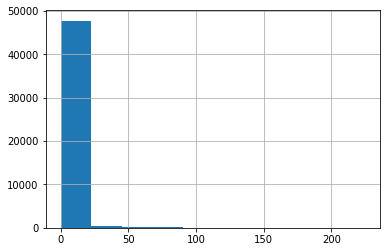

In [122]:
def calc_squared_error(y, predict):
    e = np.array(y) - np.array(predict)
    e = np.power(e, 2)
    return e
error_vec = calc_squared_error(y_test, predict_full)
error_df = pd.DataFrame(
    {'y': list(y_test),
     'squared_error': error_vec
    })
error_df["squared_error"].hist()

<B>Observation:</B> So for a very large set, the predictions are fairly accurate

In [123]:
#How man times the predictions are accurate
accurate = len(error_df[(error_df['squared_error']==0)])
total = len(error_df)
print("Accurate = ", accurate, " total = ", total)

Accurate =  3223  total =  48667


But our RMSE value is 1+. 
RMSE value of 1+ means we are predicting an additional day of hospitalization for every patient.

So, where does the RMSE value of 1+ comes from? 

Lets try to analyze the predicted values against actual values

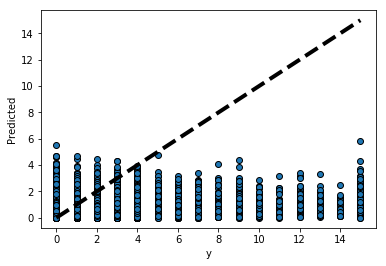

In [124]:
fig, ax = plt.subplots()
ax.scatter(y_test, predict_full, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('y')
ax.set_ylabel('Predicted')
plt.show()


<B>Observations:</B>
1. It looks like lots of 0s are predicted as 2 to 7
2. And lots of 12, 13, 14 and 15 are predicted as < 4
So, there is essentially a problem at the extreme

Lets also confirm it by plotting y against squared error

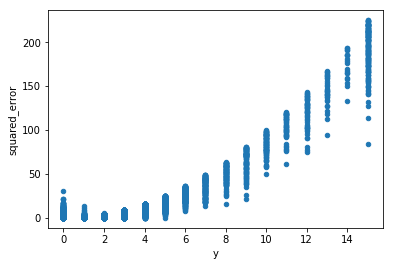

In [125]:
error_df.plot.scatter(x="y", y="squared_error")

<B>Observation</B>
Again peak at the extremes. So, our earlier observation seem to be correct

In [126]:
#Are we predicting values in same range?
print("Min and max values of y: ", np.min(y_test), np.max(y_test))
print("Min and max values of predict: ", np.min(predict_full), np.max(predict_full))

Min and max values of y:  0.0 15.0
Min and max values of predict:  0.0 5.833333333333333


In [127]:
#How many times squared error is < 1 and > 0
len(error_df[(error_df['squared_error']<1) & (error_df['squared_error']>0)])

36791

<B>Observation: </B>Can we simply fix lot of cases by taking floor of our prediction?

In [128]:
predict_full_floor = np.floor(predict_full)
error_rf_full_floor = calc_error(y_test, predict_full_floor)
rmse_rf_full_floor = calc_rmse(y_test, predict_full_floor)
print("Error = ", error_rf_full_floor)
print("RMSE = ", rmse_rf_full_floor)

Error =  0.25147869631667885
RMSE =  1.5720646240786582


In [129]:
error_vec = calc_squared_error(y_test, np.floor(predict_full))
error_df = pd.DataFrame(
    {'y': list(y_test),
     'squared_error': error_vec
    })
accurate = len(error_df[(error_df['squared_error']==0)])
total = len(error_df)
print("Accurate = ", accurate, " total = ", total)

Accurate =  37286  total =  48667


<B>Observations:</B> This is good. We should simply take floor of the prediction

<B>Observation: </B>Why is DaysInHospital=15 is missing in predicted set?

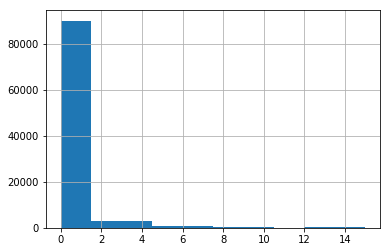

In [130]:
y_train.hist()

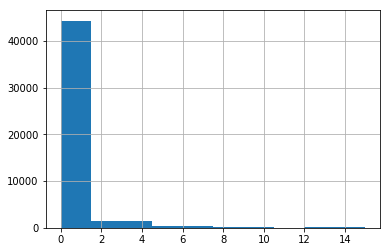

In [131]:
y_test.hist()

In [132]:
y_train.value_counts()

0.0     83702
1.0      6234
2.0      3070
3.0      1938
4.0      1226
5.0       717
6.0       454
7.0       328
15.0      320
8.0       217
9.0       168
10.0      125
11.0       97
12.0       85
13.0       79
14.0       46
Name: DaysInHospital, dtype: int64

In [133]:
y_test.value_counts()

0.0     41273
1.0      3065
2.0      1478
3.0       944
4.0       593
5.0       376
6.0       206
15.0      159
7.0       146
8.0        99
9.0        95
10.0       84
12.0       50
11.0       48
13.0       32
14.0       19
Name: DaysInHospital, dtype: int64

<B>Observtions:</B>
1. It looks like histogram of train and test set is similar
2. Train set does have examples of Days In Hospital = 15
Need to see further why 15 is missing completely in the predictions

<B>Overall Observations</B>
1. About 77% predictions are accurate
2. We should take floor of the result since DaysInHospital are always integer
3. The predictions are wrong towards boundary (at 0 and > 10)

## Additional Features
Lets try to use the features which we ignored previously
1. Sex - need one hot encoding
2. Previous Year Records - The past records of a member can be used as features for current year predictions. 

### Add Gender As a Feature

In [134]:
summary_df_m.head(2)

,MemberID,Year,ClaimsTruncated,DaysInHospital,TotalLabCount,TotalDrugCount,ProviderCount,VendorCount,MinPCP,MaxPCP,...,ProcedureGroup_nan,ProcedureGroup_SAS,ProcedureGroup_SRS,ProcedureGroup_SUS,ProcedureGroup_SO,ProcedureGroup_SMCD,AgeAtFirstClaim,Sex,AgeAtFirstClaimMin,AgeAtFirstClaimMax
0,4,Y2,0.0,0.0,NaN,NaN,1,1,31106.0,31106.0,...,0,0,0,0,0,0,0-9,M,0,9
1,210,Y1,0.0,0.0,2.0,5.0,4,4,18880.0,37508.0,...,0,0,0,0,0,0,30-39,NaN,30,39


In [135]:
sqlgender = "SELECT *, \
            (CASE WHEN Sex = 'M' THEN 1 ELSE 0 END) AS Sex_M, \
            (CASE WHEN Sex = 'F' THEN 1 ELSE 0 END) AS Sex_F \
            FROM summary_df_m"

summary_df_mg = pysqldf(sqlgender)

In [136]:
from sklearn.model_selection import train_test_split
#First divide DaysInHospital data in train and test 
y = summary_df_mg["DaysInHospital"].copy()
X = summary_df_mg.drop("DaysInHospital", axis=1) # drop labels for training set

#Drop unnecessary columns

X.drop("AgeAtFirstClaim", inplace=True, axis=1)
X.drop("Sex", inplace=True, axis=1) #check if we need this

X_train, X_test, y_train, y_test = \
                            train_test_split(X, y, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (98806, 118)
X_test shape:  (48667, 118)
y_train shape:  (98806,)
y_test shape:  (48667,)


In [137]:
num_attribs = X_train.columns
remove_cols = ["Year", "MaxLengthOfStayMin", "MinLengthOfStayMax","MaxDSFSMin", "MinDSFSMax", "MaxCharlsonIndexMin", "MinCharlsonIndexMax",\
              "AvgLengthOfStayMin", "AvgLengthOfStayMax", "AvgDSFSMin", "AvgDSFSMax", "AvgCharlsonIndexMin", "AvgCharlsonIndexMax"]
num_attribs = [x for x in num_attribs if x not in remove_cols]

In [138]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rf)
    ])

full_pipeline_with_predictor.fit(X_train, y_train)
predict_full_g = np.floor(full_pipeline_with_predictor.predict(X_test))
error_rf_full_g = calc_error(y_test, predict_full_g)
rmse_rf_full_g = calc_rmse(y_test, predict_full_g)
print("Error = ", error_rf_full_g)
print("RMSE = ", rmse_rf_full_g)

Error =  0.24915366092033428
RMSE =  1.563696785177707


### Add DaysInHospital and other important variable for Previous Year as a Feature
DaysInHospotal, LabCount, DrugCount, ClaimsCount for Y1 can be useful for predicting Y2. 
Similarly, Y2 features can be useful for predicting Y3
Lets add these features

The logic is bit complicated and explained below:
1. First find yearly count in different column (e.f. y1_tlc for year=y1 etc)
2. Then update y1 to y2, y2 to y3 etc. This is useful when we join this dataset with original big dataset. Idea is to use y1 features for y2
3. Then for year y2, rename y1_tlc to prev_year_tlc etc

In [139]:
sql_prev_year = "SELECT \
            SUM(CASE WHEN Year = 'Y1' THEN DaysInHospital ELSE 0 END) as y1_days_in_hospital,\
            SUM(CASE WHEN Year = 'Y1' THEN ClaimsTruncated ELSE 0 END) as y1_claims_truncated,\
            SUM(CASE WHEN Year = 'Y2' THEN ClaimsTruncated ELSE 0 END) as y2_claims_truncated,\
            SUM(CASE WHEN Year = 'Y1' THEN TotalLabCount ELSE 0 END) as y1_tlc,\
            SUM(CASE WHEN Year = 'Y2' THEN TotalLabCount ELSE 0 END) as y2_tlc,\
            SUM(CASE WHEN Year = 'Y1' THEN TotalDrugCount ELSE 0 END) as y1_tdc,\
            SUM(CASE WHEN Year = 'Y2' THEN TotalDrugCount ELSE 0 END) as y2_tdc,\
            MemberID, Year \
            FROM summary_df_mg \
            GROUP BY MemberId, Year"

prev_year_df = pysqldf(sql_prev_year)



In [140]:
prev_year_df.head(2)

,y1_days_in_hospital,y1_claims_truncated,y2_claims_truncated,y1_tlc,y2_tlc,y1_tdc,y2_tdc,MemberID,Year
0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,4,Y2
1,0.0,0.0,0.0,2.0,0.0,5.0,0.0,210,Y1


OK, we have yearly counts now. 
Lets use Y1 counts for Y2 records

In [141]:
prev_year_df['Year'].unique()

array(['Y2', 'Y1'], dtype=object)

In [142]:
prev_year_df.loc[(prev_year_df['Year'] == 'Y3') ,'Year'] = 'Y4'
prev_year_df.loc[(prev_year_df['Year'] == 'Y2') ,'Year'] = 'Y3'
prev_year_df.loc[(prev_year_df['Year'] == 'Y1') ,'Year'] = 'Y2'

prev_year_df['Year'].unique()

array(['Y3', 'Y2'], dtype=object)

In [143]:
renamesql = "\
SELECT MemberID, Year, \
(CASE WHEN Year = 'Y1' THEN 0 WHEN Year = 'Y2' THEN y1_days_in_hospital END) as prev_dih,\
(CASE WHEN Year = 'Y1' THEN 0 WHEN YEAR = 'Y2' THEN y1_tlc END) as prev_tlc,\
(CASE WHEN Year = 'Y1' THEN 0 WHEN YEAR = 'Y2' THEN y1_tdc END) as prev_tdc,\
(CASE WHEN Year = 'Y1' THEN 0 WHEN YEAR = 'Y2' THEN y1_claims_truncated END) as prev_ct \
FROM prev_year_df \
WHERE Year != 'Y3'"

prev_year_adj_df = pysqldf(renamesql)

In [144]:
prev_year_adj_df.count()

MemberID    76038
Year        76038
prev_dih    76038
prev_tlc    53227
prev_tdc    49838
prev_ct     76038
dtype: int64

In [145]:
prev_year_adj_df.head(2)

,MemberID,Year,prev_dih,prev_tlc,prev_tdc,prev_ct
0,210,Y2,0.0,2.0,5.0,0.0
1,3197,Y2,0.0,NaN,5.0,0.0


<B>OK, we are ready with prev_year counts now. </B>

In [146]:
summary_df_mg.head(2)

,MemberID,Year,ClaimsTruncated,DaysInHospital,TotalLabCount,TotalDrugCount,ProviderCount,VendorCount,MinPCP,MaxPCP,...,ProcedureGroup_SRS,ProcedureGroup_SUS,ProcedureGroup_SO,ProcedureGroup_SMCD,AgeAtFirstClaim,Sex,AgeAtFirstClaimMin,AgeAtFirstClaimMax,Sex_M,Sex_F
0,4,Y2,0.0,0.0,NaN,NaN,1,1,31106.0,31106.0,...,0,0,0,0,0-9,M,0,9,1,0
1,210,Y1,0.0,0.0,2.0,5.0,4,4,18880.0,37508.0,...,0,0,0,0,30-39,None,30,39,0,0


In [147]:
prev_year_adj_df.reset_index(inplace=True)
summary_df_mg.reset_index(inplace=True)

In [148]:
#Join on MemberID and Year
prev_year_adj_df.set_index(["MemberID", "Year"], inplace=True)
summary_df_mg.set_index(["MemberID", "Year"], inplace=True)
summary_df_mg_prev = summary_df_mg.join(prev_year_adj_df, on=None, how='left', rsuffix = "_1")

In [149]:
summary_df_mg_prev.head(2)

,,index,ClaimsTruncated,DaysInHospital,TotalLabCount,TotalDrugCount,ProviderCount,VendorCount,MinPCP,MaxPCP,AvgPCP,...,Sex,AgeAtFirstClaimMin,AgeAtFirstClaimMax,Sex_M,Sex_F,index_1,prev_dih,prev_tlc,prev_tdc,prev_ct
MemberID,Year,,,,,,,,,,,,,,,,,,,,,
4,Y2,0,0.0,0.0,NaN,NaN,1,1,31106.0,31106.0,31106.0,...,M,0,9,1,0,NaN,NaN,NaN,NaN,NaN
210,Y1,1,0.0,0.0,2.0,5.0,4,4,18880.0,37508.0,35179.5,...,None,30,39,0,0,NaN,NaN,NaN,NaN,NaN


<B>Prev year counts are merged with original big flat feature table </B>

## Re-create Pipeline for the new features
Follow the standard procedure of creating train-test sets, creating pipeline and testing

In [150]:
from sklearn.model_selection import train_test_split
#First divide DaysInHospital data in train and test 
y = summary_df_mg_prev["DaysInHospital"].copy()
X = summary_df_mg_prev.drop("DaysInHospital", axis=1) # drop labels for training set

#Drop unnecessary columns

X.drop("AgeAtFirstClaim", inplace=True, axis=1)
X.drop("Sex", inplace=True, axis=1) #check if we need this
X.drop("index", inplace=True, axis=1) 
X.drop("index_1", inplace=True, axis=1) 

X_train, X_test, y_train, y_test = \
                            train_test_split(X, y, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (98806, 120)
X_test shape:  (48667, 120)
y_train shape:  (98806,)
y_test shape:  (48667,)


<B>Lets perform hyper parameter tuning</B>

In [151]:
num_attribs = X_train.columns
remove_cols = ["Year", "MaxLengthOfStayMin", "MinLengthOfStayMax","MaxDSFSMin", "MinDSFSMax", "MaxCharlsonIndexMin", "MinCharlsonIndexMax",\
              "AvgLengthOfStayMin", "AvgLengthOfStayMax", "AvgDSFSMin", "AvgDSFSMax", "AvgCharlsonIndexMin", "AvgCharlsonIndexMax"]
num_attribs = [x for x in num_attribs if x not in remove_cols]

In [152]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [153]:
X_train_prepared = num_pipeline.fit_transform(X_train)
X_test_prepared = num_pipeline.fit_transform(X_test)

In [154]:
#__avoid_run_heavy_tasks__ = False

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

if __avoid_run_heavy_tasks__ == False:

    param_grid = [
        {'n_estimators': [3, 10, 30,50], 'max_features': [4, 6, 8]}
        #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    forest_reg = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
    #grid_search.fit(X_train_prepared[:1000,:], y_train[:1000])
    grid_search.fit(X_train_prepared, y_train)
    print(grid_search.best_estimator_)

In [156]:


rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rf)
    ])

full_pipeline_with_predictor.fit(X_train, y_train)
predict_full_g_prev = np.floor(full_pipeline_with_predictor.predict(X_test))
error_rf_full_g_prev = calc_error(y_test, predict_full_g_prev)
rmse_rf_full_g_prev = calc_rmse(y_test, predict_full_g_prev)
print("Error = ", error_rf_full_g_prev)
print("RMSE = ", rmse_rf_full_g_prev)

Error =  0.2443727537569598
RMSE =  1.5641829092231063


<B>A small improvement in error and RMSE</B>

<B>Significance Test</B>

In [157]:
kFolds = 10
corss_val_rf_full_g_prev = cross_val_score(full_pipeline_with_predictor, X_train, \
                             y_train,
                             scoring="neg_mean_squared_error", cv=kFolds)
corss_val_rf_full_g_prev

array([-2.24336253, -2.34368246, -2.32066333, -2.32948294, -2.05020518,
       -2.40642668, -2.44152822, -2.31750865, -2.3670689 , -2.27110889])

In [158]:
#Compare the new model with current best model 
control = results_table.loc[4]["cross_val_scores"][1:-1].split()
control = np.array(list(map(float, control)))

treatment = corss_val_rf_full_g_prev
#treatment = np.array(list(map(float, treatment)))

(p_value, t_score, result_message) = stats_compare_models(control, treatment)

8.35379294910358 1.5639371553312034e-05


In [159]:
results_table.loc[len(results_table)] = ["5", "Random Forest - Prev Year Features", 
                             error_rf_full_g_prev, rmse_rf_full_g_prev,
                             corss_val_rf_full_g_prev,p_value, t_score,  
                             'Full Prediction Pipeline With Prev Year Features using RF',
                            result_message, "Compared with Random Forest #4"]
#results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

In [160]:
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "ControlModel", "ModelComparisonResult", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,ControlModel,ModelComparisonResult,Experiment description
0,Simple logic based on finding Average for DIH,0.2436542912261619,1.541389,not calculated,not calculated,,,The mean value of DIH is calculated based on h...
1,Random Forest,0.2717722908121741,1.559120,not calculated,not calculated,,,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.25479374541837824,1.573835,0.413824,0.856728,Compared with BaseLine RF.,There is no significant difference between the...,"Feature Engineering, Parameter Tuning"
3,SVM(SVR) - After Feature Engineering,Divide by 0 error,1.651900,not calculated,not calculated,,,"Feature Engineering, Parameter Tuning"
4,Random Forest - After Feature Engineering,0.2726796902622541,1.542195,0.567284,-0.593776,Compared with RF after feature engineering.,There is no significant difference between the...,Full Prediction Pipeline
5,Random Forest - After Reducing some Features,0.274527,1.546138,not calculated,not calculated,,,Full Prediction Pipeline
6,Random Forest - Prev Year Features,0.244373,1.564183,1.56394e-05,8.35379,Machine learning pipeline B is better than A,Compared with Random Forest #4,Full Prediction Pipeline With Prev Year Featur...


In [161]:
X_train.shape

(98806, 120)

Accurate =  37618  total =  48667  precentage =  77.29673084430928


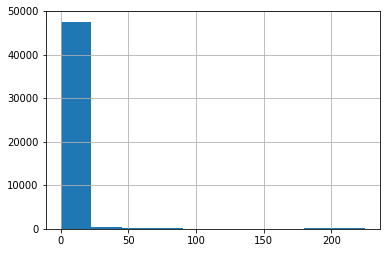

In [162]:
error_vec = calc_squared_error(y_test, predict_full_g_prev)
error_df = pd.DataFrame(
    {'y': list(y_test),
     'squared_error': error_vec
    })
accurate = len(error_df[(error_df['squared_error']==0)])
total = len(error_df)
print("Accurate = ", accurate, " total = ", total, " precentage = ", accurate*100/total)

error_df["squared_error"].hist()

## Input Feature Analysis

In [163]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(25):
    print(f+1, ".", X_train.columns[indices[f]], ":", importances[indices[f]])
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    

Feature ranking:
1 . MinPCP : 0.04323026165601431
2 . MaxPCP : 0.04285345363850772
3 . AvgPCP : 0.04216131821427438
4 . TotalDrugCount : 0.03931205517126493
5 . TotalLabCount : 0.03387654950595575
6 . PrimaryConditionGroup_STROKE : 0.03106023303864683
7 . Specialty_Internal : 0.030550046697749335
8 . MaxDSFSMin : 0.02679275516173064
9 . ProviderCount : 0.026433108662860284
10 . MinLengthOfStayMax : 0.025637995051496998
11 . VendorCount : 0.023587463925093005
12 . AvgDSFSMin : 0.023391944290896752
13 . PlaceSvc_nan : 0.023275592254376892
14 . PrimaryConditionGroup_SEPSIS : 0.02225630919855312
15 . PrimaryConditionGroup_nan : 0.021568507116020815
16 . ProcedureGroup_SIS : 0.02026489734930857
17 . Specialty_Pathology : 0.019816505753675426
18 . PrimaryConditionGroup_CANCRA : 0.018846875335408266
19 . PrimaryConditionGroup_PERVALV : 0.01785071452469946
20 . PlaceSvc_UrgentCare : 0.017354663984521554
21 . ProcedureGroup_nan : 0.017281951781065088
22 . ProcedureGroup_PL : 0.01668357370235338

<B>Observation: </B>PCP, DrugCount, LabCount and Categorical variables ProcedureGroup and PrimaryConditionGroup seem to be ge getting most importance in the decision tree ensembles. 

## Experimental Result Discussion: Phase 3 Results

The best pipeline uses:
1. 121 features which include numeric feature expansions (min, max, avg), and categorial feature encodings
2. Reducing some unnecessary features
3. Random Forest with max_features = 6 and n_estimators = 50 as determined by hyper-parameter tuning
4. Previous Year counts as features for current year predictions

Error Analysis:
1. The best log error is 0.244 and RMSE is 1.564. 
2. This is improved from error=0.27 and RMSE=1.55 which was base model. 
3. The total number of accurate predictions are 37,618 out of 48,667 (77.36%)
4. The model is not able to predict the cases when days_in_hospital > 7. These cases are cuasing maximum Error and RMSE

## Next Steps
ProviderID - we are only using ProviderCount for a member. But some providers may have high rate of hospitalization than others since they provide some special service. Can this be used as a feature?

# Phase 4

## Model Ensemble
Lets try combination of classifer followe by regression
1. The classifier will first predict whether a member will be hospitalized
2. The regressor will predict the number of days in hospital if the classifier predicts hospitalization

### Classifier: Create IsHospitalized column as label for classifier

In [164]:
summary_df_mg_prev['IsHospitalized'] = summary_df_mg_prev.apply(lambda row: 1 if row.DaysInHospital > 0 else 0, axis=1)

In [165]:
summary_df_mg_prev_hospitalized=summary_df_mg_prev.loc[summary_df_mg_prev['IsHospitalized']==1]
summary_df_mg_prev_hospitalized.shape

(22498, 126)

In [166]:
from sklearn.model_selection import train_test_split
#First divide DaysInHospital data in train and test 

#y1 = summary_df_mg_prev["IsHospitalized"].copy()
#y2 = summary_df_mg_prev["DaysInHospital"].copy()
y = summary_df_mg_prev[['IsHospitalized', 'DaysInHospital']].copy()
X = summary_df_mg_prev.drop("IsHospitalized", axis=1) # drop labels for training set
X = summary_df_mg_prev.drop("DaysInHospital", axis=1) # drop labels for training set

#Drop unnecessary columns

X.drop("AgeAtFirstClaim", inplace=True, axis=1)
X.drop("Sex", inplace=True, axis=1) #check if we need this
X.drop("index", inplace=True, axis=1) 
X.drop("index_1", inplace=True, axis=1) 

X_train, X_test, y_train, y_test = \
                            train_test_split(X, y, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (98806, 121)
X_test shape:  (48667, 121)
y_train shape:  (98806, 2)
y_test shape:  (48667, 2)


In [167]:
X_train_prepared = num_pipeline.fit_transform(X_train)
X_test_prepared = num_pipeline.fit_transform(X_test)

### Classifier Model Selection

In [168]:
__avoid_run_heavy_tasks__ = False
__avoid_run_svm__ = True

In [169]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

if __avoid_run_heavy_tasks__ == False:
    models = []
    models.append(('LINEAR', SGDClassifier(max_iter=20, tol=None)))
    models.append(('NB', GaussianNB()))
    if __avoid_run_svm__ == False:
        models.append(('SVM', SVC()))
    models.append(('RandomForest', RandomForestClassifier()))

    agg_results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = KFold(n_splits=5, random_state=7)
        #cv_results = cross_val_score(model, X_train_prepared[:1000,:], y_train[:1000], cv=kfold, scoring=scoring)
        if __name__ == "__main__":    
            cv_results = cross_val_score(model, X_train_prepared, y_train["IsHospitalized"], cv=kfold, scoring=scoring, n_jobs=-1)
        agg_results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

LINEAR: 0.839392 (0.002695)
NB: 0.772797 (0.002298)
RandomForest: 0.843248 (0.001481)


In [170]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

if __avoid_run_heavy_tasks__ == False:

    param_grid = [
        {'n_estimators': [100, 120], 'max_features': [8, 12], 'criterion':['gini', 'entropy']}
       # {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    rfc = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rfc, param_grid, cv=5,
                               scoring='accuracy')
    #grid_search.fit(X_train_prepared[:1000,:], y_train[:1000])
    grid_search.fit(X_train_prepared, y_train["IsHospitalized"])
    print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


### Classifier Pipeline

In [171]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1)

rfc_pipeline = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rfc)
    ])

rfc_pipeline.fit(X_train, y_train["IsHospitalized"])
rfc_predict = rfc_pipeline.predict(X_test)

In [172]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test["IsHospitalized"], rfc_predict)

0.849692810323217

### Regressor: Data Selection
The regressor should be trained on data where DaysInHospital >=1

In [173]:
X_train["DaysInHospital"] = y_train["DaysInHospital"]
x_train_subset = X_train[X_train["DaysInHospital"] > 0]
y_train_subset = y_train[y_train["DaysInHospital"] > 0]

x_train_subset_for_regressor_model_sel = X_train[X_train["DaysInHospital"] > 0]
y_train_subset_for_regressor_model_sel = y_train[y_train["DaysInHospital"] > 0]
x_train_subset_for_regressor_model_sel.drop("DaysInHospital", inplace=True, axis=1)
x_train_subset_for_regressor_model_sel_prepared = num_pipeline.fit_transform(x_train_subset_for_regressor_model_sel)

X_train.drop("DaysInHospital", inplace=True, axis=1)
print("x_train_subset.shape:", x_train_subset.shape, "y_train_subset.shape: ", y_train_subset.shape)

/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


x_train_subset.shape: (15104, 122) y_train_subset.shape:  (15104, 2)


/Users/Avadhoot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Regressor: Model Selection

In [174]:
#Model Selection for Regressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

if __avoid_run_heavy_tasks__ == False:
    models = []
    models.append(('LINEAR', LinearRegression()))
    models.append(('Lasso', Lasso()))
    #models.append(('LR', LogisticRegression()))
    models.append(('NB', GaussianNB()))
    if __avoid_run_svm__ == False:
        models.append(('SVM', SVR()))
    models.append(('RandomForest', RandomForestRegressor()))

    agg_results = []
    names = []
    scoring = 'neg_mean_squared_error'
    for name, model in models:
        kfold = KFold(n_splits=5, random_state=7)
        #cv_results = cross_val_score(model, X_train_prepared[:1000,:], y_train[:1000], cv=kfold, scoring=scoring)
        if __name__ == "__main__":    
            cv_results = cross_val_score(model, x_train_subset_for_regressor_model_sel_prepared, \
                                         y_train_subset["DaysInHospital"], cv=kfold, scoring=scoring, n_jobs=-1)
        agg_results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        

LINEAR: -8.183055 (0.181984)
Lasso: -8.716705 (0.159061)
NB: -115.210035 (2.294855)
RandomForest: -9.204785 (0.072867)


The execution output was:

LINEAR: -8.183055 (0.181984)

Lasso: -8.716705 (0.159061)

NB: -115.210035 (2.294855)

SVM: -9.117708 (0.171438)

RandomForest: -9.199083 (0.142283)

### Regressor: Linear Regression Pipeline

In [175]:
lr = LinearRegression()

lrpipeline = Pipeline([
        ("preparation", num_pipeline),
        ("linear regression", lr)
    ])
lrpipeline.fit(x_train_subset, y_train_subset["DaysInHospital"])

Pipeline(memory=None,
     steps=[('preparation', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['ClaimsTruncated', 'TotalLabCount', 'TotalDrugCount', 'ProviderCount', 'VendorCount', 'MinPCP', 'MaxPCP', 'AvgPCP', 'MinLengthOfStayMin', 'MaxLengthOfStayMax', 'MinDSFSMin', 'MaxDSFSMax', 'MinCha...('linear regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [176]:
lr_predict = np.floor(lrpipeline.predict(X_test))

### Regressor: Random Forest: Hyper-parameter Tuning

In [177]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

if __avoid_run_heavy_tasks__ == False:

    param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}
        #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    forest_reg = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
    #grid_search.fit(X_train_prepared[:1000,:], y_train[:1000])
    grid_search.fit(x_train_subset_for_regressor_model_sel_prepared, y_train_subset["DaysInHospital"])
    print(grid_search.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


The execution output:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

### Regressor: Random Forest: Pipeline

In [178]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

rfr = Pipeline([
        ("preparation", num_pipeline),
        ("random forest", rf)
    ])
rfr.fit(x_train_subset, y_train_subset["DaysInHospital"])

Pipeline(memory=None,
     steps=[('preparation', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['ClaimsTruncated', 'TotalLabCount', 'TotalDrugCount', 'ProviderCount', 'VendorCount', 'MinPCP', 'MaxPCP', 'AvgPCP', 'MinLengthOfStayMin', 'MaxLengthOfStayMax', 'MinDSFSMin', 'MaxDSFSMax', 'MinCha...estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))])

In [179]:

rfr_predict = np.floor(rfr.predict(X_test))


### Kitchen Sink: Merger the results for 2 Regressors

In [180]:
wt_linear = 0.6
wt_rf = 0.4
regress_predict = wt_linear * lr_predict + wt_rf * rfr_predict
regress_predict

array([1.6, 1. , 3. , ..., 1.6, 1.6, 2. ])

### Merge Classifier and Regressor Results

In [181]:
predict_df = pd.DataFrame({'IsHospitalized':rfc_predict, 'DaysInHospital':regress_predict})
predict_df['DaysInHospitalFinal'] = predict_df.apply(lambda row: row.DaysInHospital if row.IsHospitalized > 0 else 0, axis=1)

In [182]:
error_sink = calc_error(np.array(y_test["DaysInHospital"]), \
                        np.array(predict_df["DaysInHospitalFinal"]))
rmse_sink = calc_rmse(np.array(y_test["DaysInHospital"]), \
                      np.array(predict_df["DaysInHospitalFinal"]))
print("Error = ", error_sink)
print("RMSE = ", rmse_sink)

Error =  0.2609802768974819
RMSE =  1.628421515395781


### Result Table

In [183]:
results_table.loc[len(results_table)] = ["6", "Model Ensembles", 
                             error_sink, rmse_sink,
                             [],"not calculated", "not calculated",  
                             'Random Forest as Classifier for IsHospitalized. Then Linear and Random Forest Regression',
                            "", ""]
#results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "Experiment description"]]

In [184]:
results_table[["Experiment", "Error (Test)", "RMSE (Test)", "p_value", "t_score", "ControlModel", "ModelComparisonResult", "Experiment description"]]

,Experiment,Error (Test),RMSE (Test),p_value,t_score,ControlModel,ModelComparisonResult,Experiment description
0,Simple logic based on finding Average for DIH,0.2436542912261619,1.541389,not calculated,not calculated,,,The mean value of DIH is calculated based on h...
1,Random Forest,0.2717722908121741,1.559120,not calculated,not calculated,,,Only numeric fields which are directly availab...
2,Random Forest - After Feature Engineering,0.25479374541837824,1.573835,0.413824,0.856728,Compared with BaseLine RF.,There is no significant difference between the...,"Feature Engineering, Parameter Tuning"
3,SVM(SVR) - After Feature Engineering,Divide by 0 error,1.651900,not calculated,not calculated,,,"Feature Engineering, Parameter Tuning"
4,Random Forest - After Feature Engineering,0.2726796902622541,1.542195,0.567284,-0.593776,Compared with RF after feature engineering.,There is no significant difference between the...,Full Prediction Pipeline
5,Random Forest - After Reducing some Features,0.274527,1.546138,not calculated,not calculated,,,Full Prediction Pipeline
6,Random Forest - Prev Year Features,0.244373,1.564183,1.56394e-05,8.35379,Machine learning pipeline B is better than A,Compared with Random Forest #4,Full Prediction Pipeline With Prev Year Featur...
7,Model Ensembles,0.26098,1.628422,not calculated,not calculated,,,Random Forest as Classifier for IsHospitalized...


## Conclusion

The best pipeline (#6) uses:

1. 121 features which include numeric feature expansions (min, max, avg), and categorial feature encodings
2. Reducing some unnecessary features
3. Random Forest with max_features = 6 and n_estimators = 50 as determined by hyper-parameter tuning
4. Previous Year counts as features for current year predictions

Error Analysis:

1. The best log error is 0.244 and RMSE is 1.564.
2. This is improved from error=0.27 and RMSE=1.55 which was base model.
3. The total number of accurate predictions are 37,618 out of 48,667 (77.36%)
4. The model is not able to predict the cases when days_in_hospital > 7. These cases are cuasing maximum Error and RMSE

Next Steps:

1. The ProviderID is used in very limited way. We are only finding distinct count per Member and using it as feature. However, Provider specific average of days_in_hospital can be useful feature
2. Using advanced techniques like Deep Learning
3. The major issue is the inability of model to predict the the cases when days_in_hospital > 7. Need to gather more data for these cases.
4. Data cleansing: Some domain expertise might be useful to validate the data and remove incorrect data